In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

RS = 42

In [2]:
data = pd.read_csv('./heart.csv')
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# separate our dataset into 
cat_columns = data.select_dtypes(include=["object"]).columns.tolist()
print("Categorical Columns: " , cat_columns)
num_columns = data.select_dtypes(exclude=["object"]).columns.tolist()
print("Numerical Columns: " , num_columns)

Categorical Columns:  ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical Columns:  ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


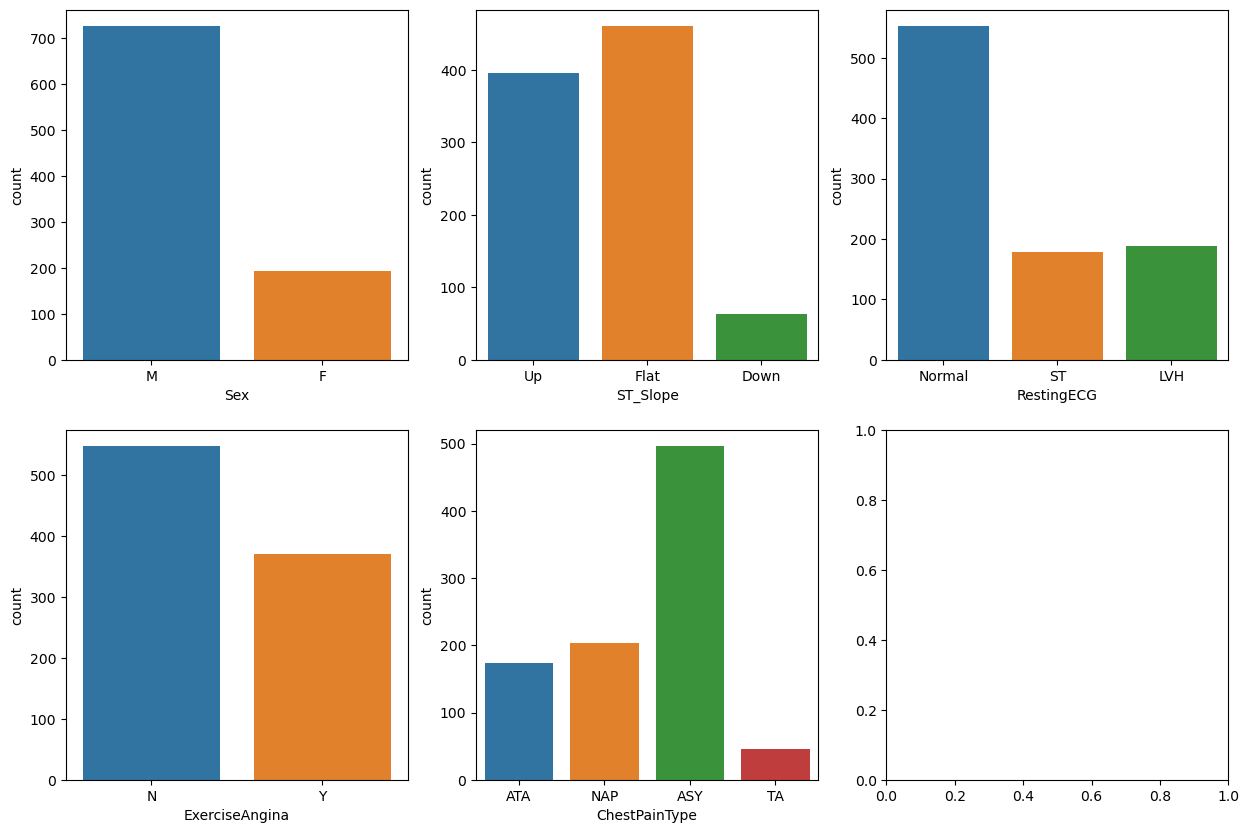

In [6]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(cat_columns):
    sns.countplot(x = data[col], data = data, ax=axes[i%2,i%3])
    
plt.show()

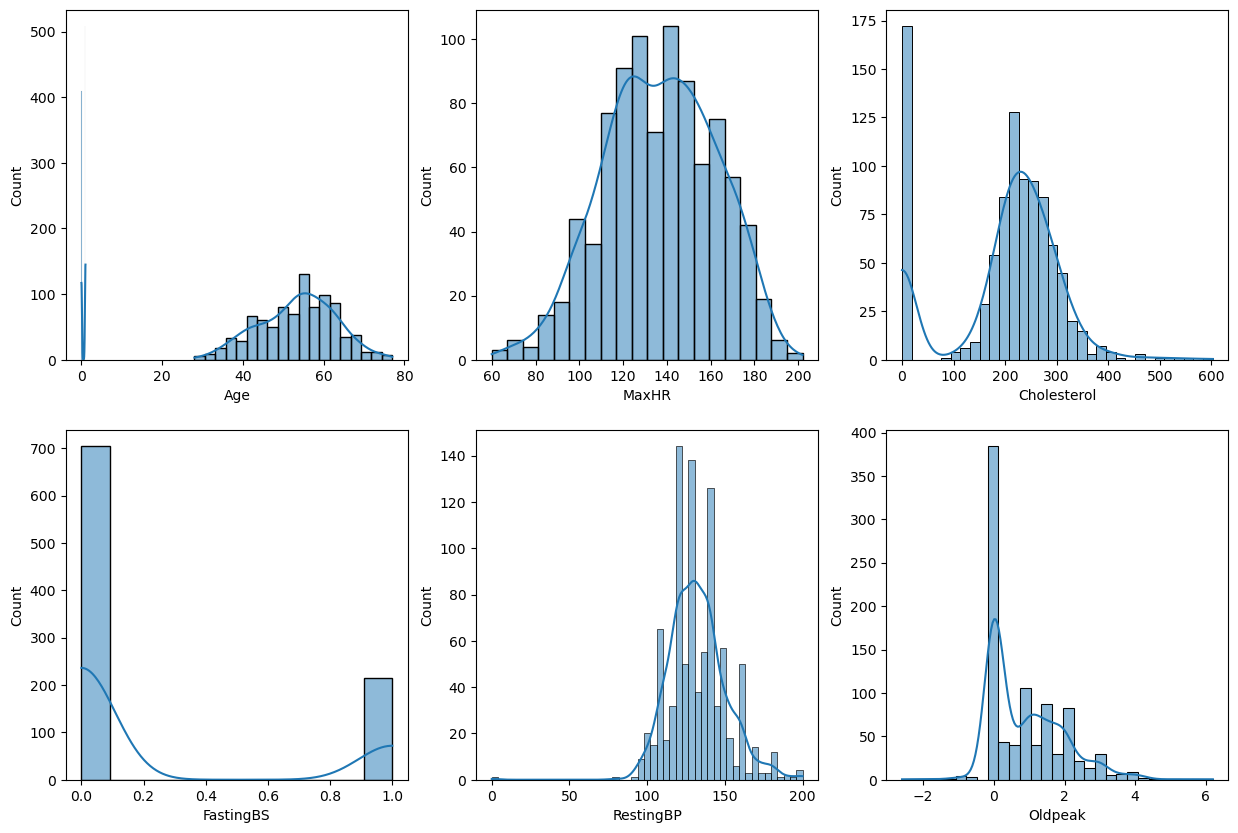

In [7]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(num_columns):
    sns.histplot(x = data[col], data = data, kde=True, ax=axes[i%2,i%3])

plt.show()

In [8]:
# missing values

print("- null values:")
print(data.isnull().sum())

print("- number of duplicated values:")
print(data.duplicated().sum())

print("- number of zero values:")
print((data == 0).sum())


- null values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
- number of duplicated values:
0
- number of zero values:
Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64


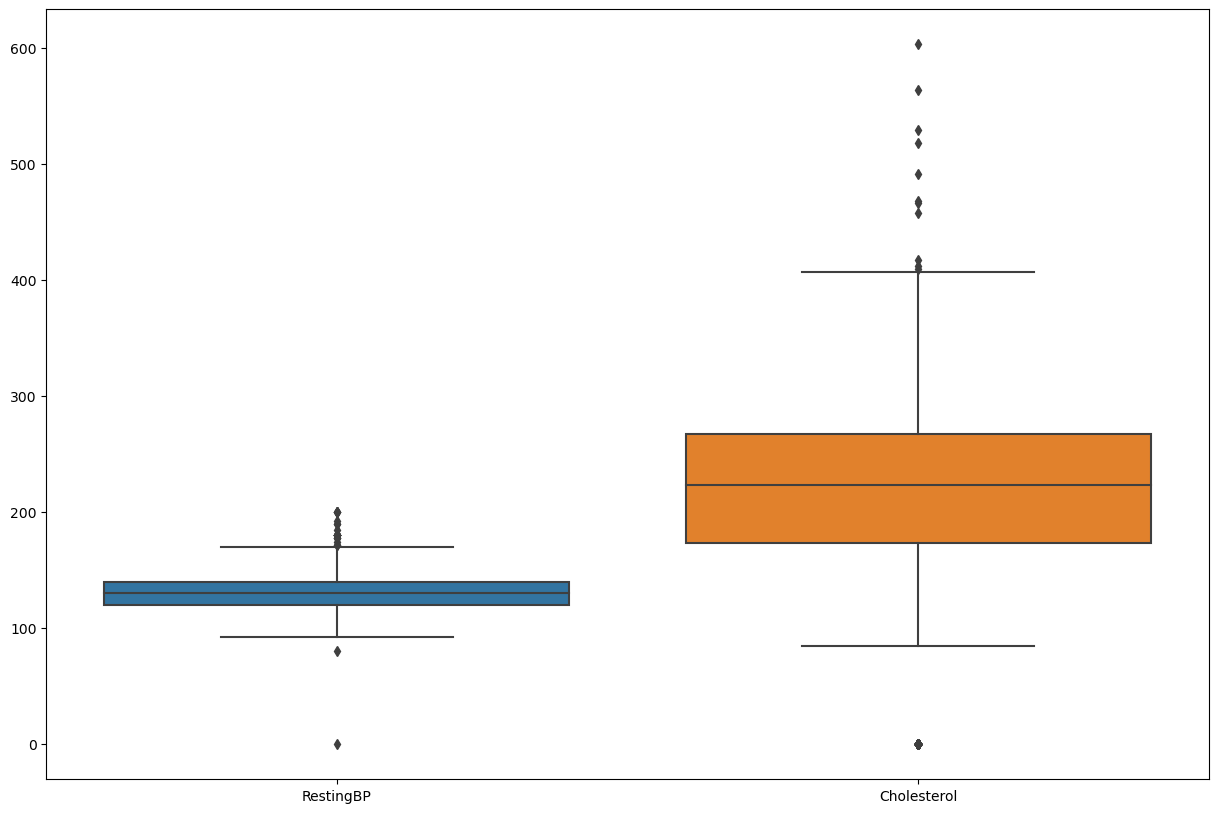

In [9]:
# checking for outliers

# RestingBP > 0
# Cholesterol > 0

f, axes = plt.subplots(figsize=(15, 10))

sns.boxplot(data=data[["RestingBP", "Cholesterol"]])  

plt.show() # we have outliers on the features

In [10]:
# Replacing missing values with median

data_to_change = data[["RestingBP", "Cholesterol"]]
data_to_change = data_to_change.replace(to_replace= 0, value = np.nan)
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
data_to_change = pd.DataFrame(imputer.fit_transform(data_to_change), columns=["RestingBP", "Cholesterol"])

for column in data_to_change.columns.tolist():
    data[column] = data_to_change[column]

print((data == 0).sum())


Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol         0
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64


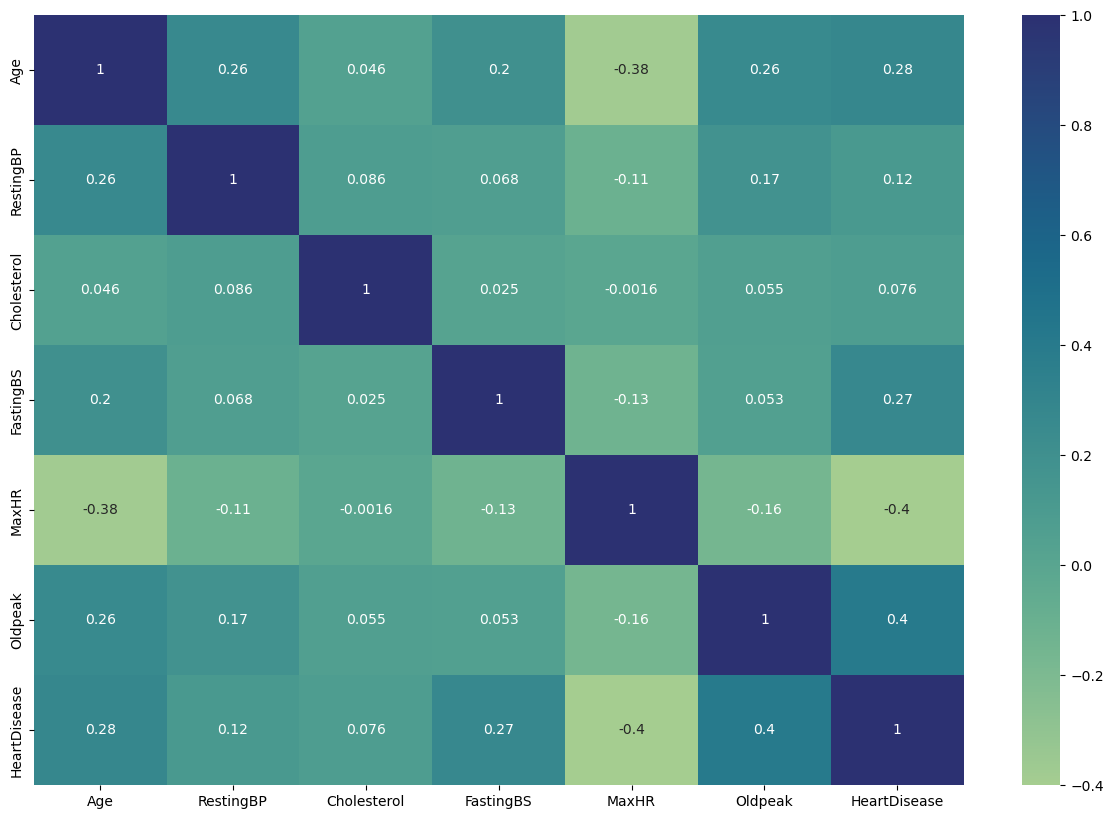

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap="crest")
plt.show()

In [12]:
# encoding categorical features

data_label_encoded = data.copy()
data_label_encoded_cat = data_label_encoded[cat_columns].copy()
data_one_hot_encoded = pd.get_dummies(data, drop_first=True)

encoderModel = data_label_encoded_cat.apply(LabelEncoder().fit)
for col in cat_columns:
    data_label_encoded[col] = LabelEncoder().fit_transform(data[col])

In [13]:
# spliting train and test sets

X = data_label_encoded.drop(data_label_encoded.columns.tolist().pop(), axis=1)
Y = data_label_encoded.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=RS, stratify=Y)
#stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.

In [14]:
# data standardization

num_columns_array = data.describe().columns

num_columns_array = num_columns_array.drop(["HeartDisease"])

X_train_numeric = X_train[num_columns_array].copy()
X_test_numeric = X_test[num_columns_array].copy()

scalerModel = StandardScaler().fit(X_train_numeric)

X_train_numeric_st = scalerModel.transform(X_train_numeric)
X_test_numeric_st = scalerModel.transform(X_test_numeric)


X_train[num_columns_array] = X_train_numeric_st
X_test[num_columns_array] = X_test_numeric_st

In [15]:
predictions = {}

In [16]:
RF = RandomForestClassifier(random_state=RS)
RF.fit(X_train, Y_train)
predictions["RF"] = RF.predict(X_test)

In [17]:
KNN_grid_dict = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], "p": [1, 2]}
# we have used p (1 or 2) because the default metric for KNN is Minkowski and we want to know Manhattan is better or Euclidean
KNN_for_gs = KNeighborsClassifier()
KNN_gs = GridSearchCV(KNN_for_gs, param_grid=KNN_grid_dict)
KNN_gs.fit(X_train, Y_train)
print(KNN_gs.best_params_)

KNN = KNN_gs.best_estimator_
predictions["KNN"] = KNN.predict(X_test)

{'n_neighbors': 5, 'p': 1}


In [18]:
SVC_grid_dict = [
    {"kernel": ["linear", "rbf"], "C":[0.01, 0.1, 1, 10, 100, 1000]},
    {"kernel": ['poly'], "degree": [2,3,4]} # It will calculate the dot product of any pair of object in a mapped space
    ]
# C will is for the accuracy of hyperplance margin
SVC_for_gs = SVC(random_state=RS)
SVC_gs = GridSearchCV(SVC_for_gs, param_grid=SVC_grid_dict)
SVC_gs.fit(X_train, Y_train)
print(SVC_gs.best_params_)

SVC = SVC_gs.best_estimator_
predictions["SVC"] = SVC.predict(X_test)

{'C': 1, 'kernel': 'rbf'}


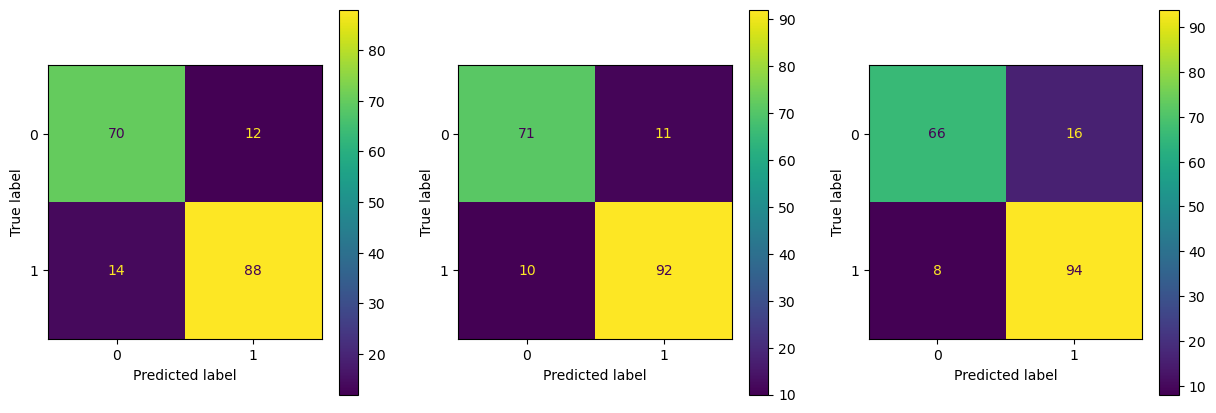

In [19]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(Y_test, predictions["RF"], ax=axes[0])
ConfusionMatrixDisplay.from_predictions(Y_test, predictions["KNN"], ax=axes[1])
ConfusionMatrixDisplay.from_predictions(Y_test, predictions["SVC"], ax=axes[2])
plt.show()

In [20]:
evaluations = {}
for c in ["RF", "KNN", "SVC"]:
    if not c in evaluations:
        evaluations[c] = []

    evaluations[c].append(accuracy_score(Y_test, predictions[c]))
    evaluations[c].append(precision_score(Y_test, predictions[c]))
    evaluations[c].append(recall_score(Y_test, predictions[c]))
    evaluations[c].append(f1_score(Y_test, predictions[c]))
    evaluations[c].append(roc_auc_score(Y_test, predictions[c]))

evaluation_df = pd.DataFrame.from_dict(evaluations, orient="index", columns=["Accuracy", "Precision", "Recall", "F1", "AUC"])
evaluation_df = evaluation_df.sort_values(by="AUC", ascending=False)
evaluation_df = evaluation_df.style.highlight_max(color="darkgreen")

evaluation_df


,Accuracy,Precision,Recall,F1,AUC
KNN,0.885870,0.893204,0.901961,0.897561,0.883907
SVC,0.869565,0.854545,0.921569,0.886792,0.863223
RF,0.858696,0.880000,0.862745,0.871287,0.858202


In [21]:
joblib.dump(encoderModel, "encoderModel.pkl")
joblib.dump(scalerModel, "scalerModel.pkl")
joblib.dump(KNN, "KNN.pkl")

['KNN.pkl']